In [17]:
import numpy as np
import pandas as pd
import math

# Taylor 

In [20]:
df = pd.read_csv('main_data_n.csv')
df.head()  # Display

,Exp,v (m/min),f (mm/rev),Time min)
0,1,105,0.15,203.0
1,2,105,0.20,223.0
2,3,105,0.30,44.0
3,4,140,0.15,102.0
4,5,140,0.20,60.0


In [22]:
df

,Exp,v (m/min),f (mm/rev),Time min)
0,1,105,0.15,203.0
1,2,105,0.20,223.0
2,3,105,0.30,44.0
3,4,140,0.15,102.0
4,5,140,0.20,60.0
5,6,140,0.30,3.0
6,7,170,0.15,68.0
7,8,170,0.20,35.0
8,9,170,0.30,82.0
9,10,200,0.15,48.0


In [24]:
log_v=np.log(df['v (m/min)'].to_numpy())
log_T=np.log(df['Time min)'].to_numpy())
log_f=np.log(df['f (mm/rev)'].to_numpy())

In [26]:
cons = np.ones(12)
y = np.zeros((12, 1))
X = np.column_stack((log_T ,log_f,  -cons, ))

In [28]:
y=-log_v.reshape(12,1)

In [30]:
x=np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y) )
x=x.reshape(3)
x

array([0.11087495, 0.3804993 , 4.79317967])

In [32]:
c=math.exp(x[2])
n=x[0]
m=x[1]
c,n,m

(120.68449647908311, 0.11087494974641172, 0.38049930363896606)

# Gaussian_Process

In [35]:
X_data = np.column_stack((np.log(df['v (m/min)'].to_numpy()), np.log(df['f (mm/rev)'].to_numpy()) ))
y_data  = np.log(df['Time min)'].to_numpy()).reshape(12,1)

## covariance martix

In [38]:
# covariance matrix
gamma=0.5
sf=1
p=1
gamma2=gamma**2 # gamma squared
K = np.zeros((12,12))
for i in range (12):
   for j in range (12): 
     K[i,j]=sf*math.exp(-(np.linalg.norm(X_data[i,:]-X_data[j,:])**p)/(gamma))
k_inv=np.linalg.inv(K)
K_inv_y=np.dot(k_inv ,y_data)

## New input data 20*20

In [41]:
dv_sample = (200-105)/(20-1)
df_sample = (0.3-0.15)/(20-1)
v_set = np.zeros(20)
f_set = np.zeros(20)
for i in range(20):
   v_set[i]    = np.log(105  + i*dv_sample)
   f_set[i]    = np.log(0.15 + i*df_sample)
New_data = np.array([[i, j] for i in v_set for j in f_set]) # this is the taylor predection,
T_taylor =  np.array([[ (1/n)*(np.log(c) - i -m*j) ] for i in v_set for j in f_set])
Taylor = T_taylor.reshape(20,20).T

## GP predection

In [44]:
n_data=400  # as 20*20 = 400 data points
# k for each x
k_x  = np.zeros(12)
T_GP = np.zeros(n_data) # mean
T_GP_dev = np.zeros(n_data) # N(mean , var)

variance_input   = np.zeros(n_data) # for posteriori
deviation_input  =  np.zeros(n_data) # for Posterior
for j in range (n_data): 
  for i in range (12):
    k_x[i]=sf*math.exp(-(np.linalg.norm(X_data[i,:]-New_data[j,:])**p)/(gamma))
  T_GP[j]= np.dot(k_x.reshape(1,12),K_inv_y)[0,0]
  variance_input[j]=sf - np.dot(k_x.reshape(1,12) , np.dot(k_inv ,k_x.reshape(12,1)))[0,0]
  T_GP_dev[j]= np.random.normal(T_GP[j], np.abs(variance_input[j]))

#deviation_input = np.sqrt(variance_input)
New_data_GP= np.column_stack((New_data[:,0] , New_data[:,1] ,T_GP)) 
GP=T_GP.reshape(20,20).T
T_GP_dev=T_GP_dev.reshape(20,20).T

# Plotting 

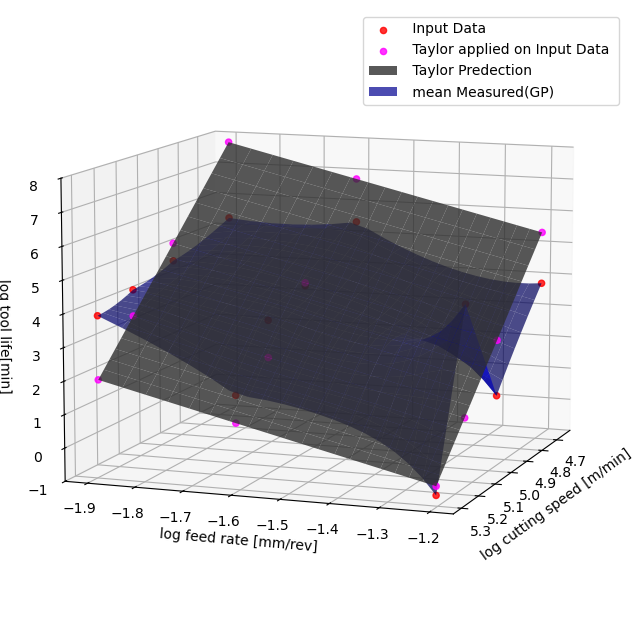

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of points
x_plot, y_plot = np.meshgrid( v_set , f_set )     # Create a meshgrid

# Create a figure for the plot
fig = plt.figure(figsize=(10, 8))

# Create a 3D axis object
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_data[:,0],X_data[:,1], y_data[:,0], color='red', alpha=0.8, label = ' Input Data ') 
ax.scatter(X_data[:,0],X_data[:,1], (1/n)*(np.log(c) - X_data[:,0] -X_data[:,1]*m) , color='magenta', alpha=0.8, label = ' Taylor applied on Input Data ') 
# Plot the first surface
ax.plot_surface(x_plot, y_plot, Taylor, color='gray', alpha=0.8, label = ' Taylor Predection ')  # alpha=0.7 makes it semi-transparent

# Plot the second surface
ax.plot_surface(x_plot, y_plot, GP, color='blue', alpha=0.7, label = ' mean Measured(GP) ')  # Different colormap for the second surface


# Add labels to the axes
ax.set_zlabel('log tool life[min]')
ax.set_xlabel('log cutting speed [m/min]')
ax.set_ylabel('log feed rate [mm/rev]')
ax.set_zlim(-1, 8)  # Adjust this range according to your data
ax.view_init(elev=10, azim=20, roll=0)  # You can adjust these values

ax.legend(loc='upper right')
# Show the plot
plt.show()



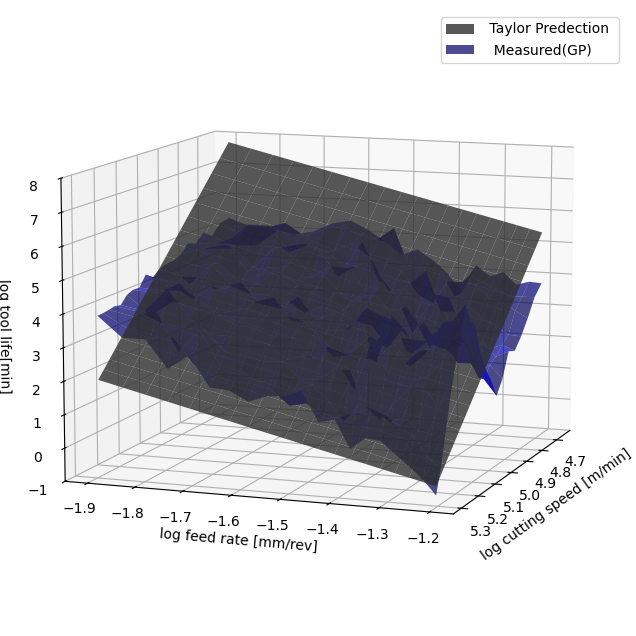

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of points
x_plot, y_plot = np.meshgrid( v_set , f_set )     # Create a meshgrid

# Create a figure for the plot
fig = plt.figure(figsize=(10, 8))

# Create a 3D axis object
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(X_data[:,0],X_data[:,1], y_data[:,0], color='red', alpha=0.8, label = ' Input Data ') 
#ax.scatter(X_data[:,0],X_data[:,1], (1/n)*(np.log(c) - X_data[:,0] -X_data[:,1]*m) , color='magenta', alpha=0.8, label = ' Taylor applied on Input Data ') 
# Plot the first surface
ax.plot_surface(x_plot, y_plot, Taylor, color='gray', alpha=0.8, label = ' Taylor Predection ')  

# Plot the second surface
ax.plot_surface(x_plot, y_plot, T_GP_dev, color='blue', alpha=0.7, label = '  Measured(GP) ')  


# Add labels to the axes
ax.set_zlabel('log tool life[min]')
ax.set_xlabel('log cutting speed [m/min]')
ax.set_ylabel('log feed rate [mm/rev]')
ax.set_zlim(-1, 8)  # Adjust this range according to your data
ax.view_init(elev=10, azim=20, roll=0)  # You can adjust these values

ax.legend(loc='upper right')
# Show the plot
plt.show()



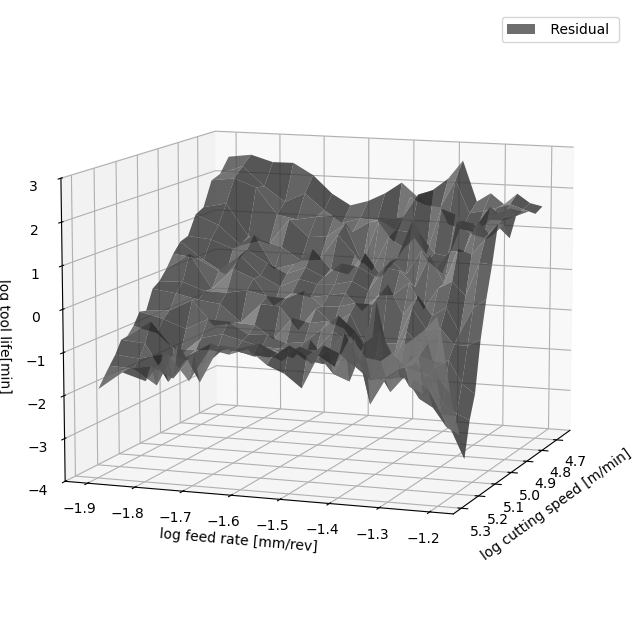

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of points
x_plot, y_plot = np.meshgrid( v_set , f_set )     # Create a meshgrid

# Create a figure for the plot
fig = plt.figure(figsize=(10, 8))

# Create a 3D axis object
ax = fig.add_subplot(111, projection='3d')

# Plot the first surface
ax.plot_surface(x_plot, y_plot, Taylor-T_GP_dev, color='gray', alpha=0.8, label = ' Residual ')  # alpha=0.7 makes it semi-transparent

# Add labels to the axes
ax.set_zlabel('log tool life[min]')
ax.set_xlabel('log cutting speed [m/min]')
ax.set_ylabel('log feed rate [mm/rev]')
ax.set_zlim(-2, 3)  # Adjust this range according to your data
ax.view_init(elev=10, azim=20, roll=0)  # You can adjust these values
ax.set_zlim(-4, 3)  # Adjust this range according to your data

ax.legend(loc='upper right')
# Show the plot
plt.show()

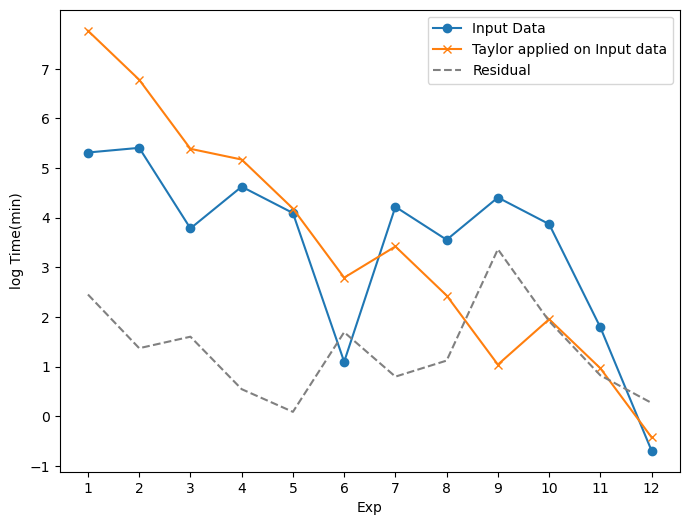

In [119]:

plt.figure(figsize=(8, 6))
x_plot = np.linspace(1, 12,12)

plt.plot(x_plot ,y_data[:,0]  ,'-o', label='Input Data')

plt.plot(x_plot , (1/n)*(np.log(c) - X_data[:,0] -X_data[:,1]*m),'-x', label='Taylor applied on Input data' )
plt.plot(x_plot , np.abs ( (1/n)*(np.log(c) - X_data[:,0] -X_data[:,1]*m) -y_data[:,0] ) ,'--',color='gray', label='Residual' )

plt.xlabel('Exp')
plt.ylabel('log Time(min)')
#plt.title('Multivariate Normal Samples (11 Dimensions)')
plt.legend()
plt.xticks(range(1, 13))
plt.yticks(range(-1, 8))

plt.grid(False)
plt.show()

In [101]:
np.max ( np.abs ( (1/n)*(np.log(c) - X_data[:,0] -X_data[:,1]*m) -log_T))

3.365076838599034

In [103]:
np.min ( np.abs ( (1/n)*(np.log(c) - X_data[:,0] -X_data[:,1]*m) -log_T))

0.08989413643412458

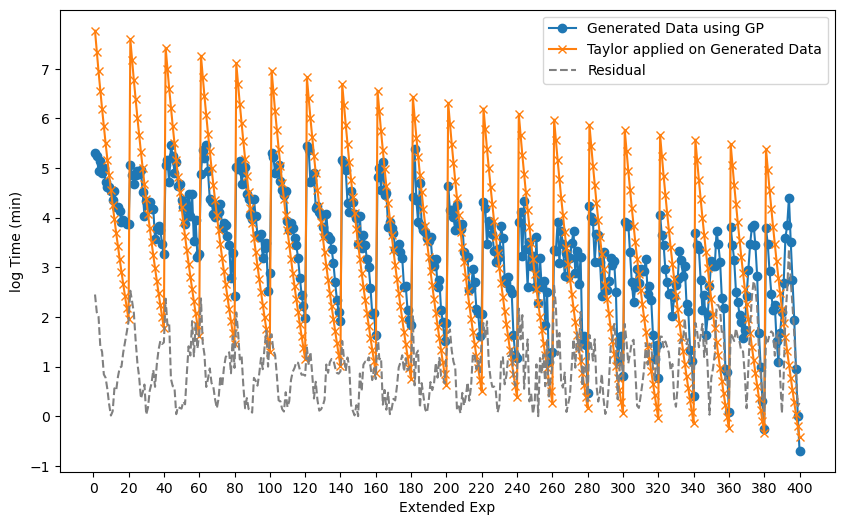

In [115]:

plt.figure(figsize=(10, 6))
x_plot = np.linspace(1, 400,400)

plt.plot(x_plot ,T_GP_dev.reshape(400) ,'-o', label='Generated Data using GP')

plt.plot(x_plot , Taylor.reshape(400) ,'-x', label='Taylor applied on Generated Data' )
plt.plot(x_plot , np.abs ( T_GP_dev.reshape(400) -Taylor.reshape(400)) ,'--',color='gray', label='Residual' )

plt.xlabel('Extended Exp')
plt.ylabel('log Time (min)')
#plt.title('Multivariate Normal Samples (11 Dimensions)')
plt.legend()
plt.xticks(range(0, 420,20))
plt.yticks(range(-1, 8))

plt.grid(False)
plt.show()

In [107]:
np.max ( np.abs ( T_GP_dev.reshape(400) -Taylor.reshape(400) ))

3.3650768385990366

In [109]:
np.min ( np.abs ( T_GP_dev.reshape(400) -Taylor.reshape(400) ))

0.002370835884693445